In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import *
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import feature_selection
from project8 import *
%matplotlib inline

# Project 8 : prédiction du prix du WTI

*Pierre-Eloi Ragetly*

Lorsque l'on souhaite modéliser des séries temporelles (données dépendant du temps), le plus souvent on va étudier les données passées afin d'y décerner une tendance et/ou une saisonnalité. Cette étude du passé va nous permettre ensuite de prédire les données futures. Pour cela, la technique privilégiée actuellement est le modèle ARIMA (ou SARIMA si présence de saisonnalité).

Malheureusement, pour la prédiction du prix du baril de pétrole brut (Brent, WTI, etc....) ce type de modèle ne donne pas de meilleurs résultats qu'une prédiction naïve (cf. annexe 1). Prédiction qui consisterait à  modéliser les prix futurs par une constante égale à la dernière donnée disponible. 
La raison est qu'une multitude de paramètres vont influencer le prix. Paramètres géopolitiques, géologiques, économiques... Ils sont aussi nombreux que divers. Ainsi, espérer modéliser un problème aussi complexe seulement à partir des données passées, parait bien illusoire.

**Le but de ce projet est de trouver un modèle relativement simple, permettant d'obtenir de meilleurs résultats à court terme (<6 mois) que le modèle naïf décrit précédemment.**

Pour ce faire nous utiliserons les données issues de **l'U.S. Energy Information Administration**. Pourquoi se restreindre aux USA, alors que le pétrole est un bien mondialisé et non spécifique à la zone nord américaine ?  
Tout d'abord parce que peu de pays possèdent des bases de données aussi exhaustives et de bonne qualité que celles des USA.  
De plus, les USA étant à la fois la première puissance économique mondiale, le premier producteur et le plus gros consommateur de pétrole au monde ; il y a de forte chance qu'ils aient un impact majeur sur le prix du baril.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Visualisation-des-données-et-choix-de-la-période-d'entrainement." data-toc-modified-id="Visualisation-des-données-et-choix-de-la-période-d'entrainement.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Visualisation des données et choix de la période d'entrainement.</a></span></li><li><span><a href="#Première-modélisation-du-prix-par-régression-linéaire-multiple" data-toc-modified-id="Première-modélisation-du-prix-par-régression-linéaire-multiple-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Première modélisation du prix par régression linéaire multiple</a></span><ul class="toc-item"><li><span><a href="#Choix-des-variables-explicatives" data-toc-modified-id="Choix-des-variables-explicatives-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Choix des variables explicatives</a></span></li><li><span><a href="#Préparation-des-données" data-toc-modified-id="Préparation-des-données-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Préparation des données</a></span></li><li><span><a href="#Premiers-résultats" data-toc-modified-id="Premiers-résultats-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Premiers résultats</a></span></li><li><span><a href="#Vérification-de-la-linéarité" data-toc-modified-id="Vérification-de-la-linéarité-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Vérification de la linéarité</a></span></li><li><span><a href="#Vérification-de-l'indépendance-des-exogènes" data-toc-modified-id="Vérification-de-l'indépendance-des-exogènes-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Vérification de l'indépendance des exogènes</a></span></li></ul></li><li><span><a href="#Modification-des-exogènes" data-toc-modified-id="Modification-des-exogènes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modification des exogènes</a></span><ul class="toc-item"><li><span><a href="#Modification-de-la-variable-production" data-toc-modified-id="Modification-de-la-variable-production-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Modification de la variable production</a></span></li><li><span><a href="#Modification-de-la-variable-demande" data-toc-modified-id="Modification-de-la-variable-demande-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Modification de la variable demande</a></span></li><li><span><a href="#Modification-de-la-variable-Stock" data-toc-modified-id="Modification-de-la-variable-Stock-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Modification de la variable Stock</a></span></li></ul></li><li><span><a href="#Nouvelle-régression-linéaire-multiple-avec-la-production-décalée-de-12-mois" data-toc-modified-id="Nouvelle-régression-linéaire-multiple-avec-la-production-décalée-de-12-mois-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Nouvelle régression linéaire multiple avec la production décalée de 12 mois</a></span><ul class="toc-item"><li><span><a href="#Analyse-des-résidus-et-vérification-de-l'indépendance-des-exogènes" data-toc-modified-id="Analyse-des-résidus-et-vérification-de-l'indépendance-des-exogènes-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Analyse des résidus et vérification de l'indépendance des exogènes</a></span></li><li><span><a href="#Régularisation" data-toc-modified-id="Régularisation-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Régularisation</a></span></li><li><span><a href="#Visualisation-des-résultats" data-toc-modified-id="Visualisation-des-résultats-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Visualisation des résultats</a></span></li></ul></li><li><span><a href="#Prédiction-du-prix-du-WTI" data-toc-modified-id="Prédiction-du-prix-du-WTI-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Prédiction du prix du WTI</a></span><ul class="toc-item"><li><span><a href="#Prédiction-des-Stocks" data-toc-modified-id="Prédiction-des-Stocks-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Prédiction des Stocks</a></span><ul class="toc-item"><li><span><a href="#Analyse-de-la-tendance-et-de-la-saisonnalité" data-toc-modified-id="Analyse-de-la-tendance-et-de-la-saisonnalité-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Analyse de la tendance et de la saisonnalité</a></span></li><li><span><a href="#Analyse-des-fonction-d'autocorrélations" data-toc-modified-id="Analyse-des-fonction-d'autocorrélations-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Analyse des fonction d'autocorrélations</a></span></li><li><span><a href="#Vérification-des-hypothèses" data-toc-modified-id="Vérification-des-hypothèses-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>Vérification des hypothèses</a></span></li><li><span><a href="#Visualisation-de-la-prédiction-des-stocks" data-toc-modified-id="Visualisation-de-la-prédiction-des-stocks-5.1.4"><span class="toc-item-num">5.1.4&nbsp;&nbsp;</span>Visualisation de la prédiction des stocks</a></span></li></ul></li><li><span><a href="#Prédiction-des-Consommations" data-toc-modified-id="Prédiction-des-Consommations-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Prédiction des Consommations</a></span><ul class="toc-item"><li><span><a href="#Analyse-de-la-tendance-et-de-la-saisonnalité" data-toc-modified-id="Analyse-de-la-tendance-et-de-la-saisonnalité-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Analyse de la tendance et de la saisonnalité</a></span></li><li><span><a href="#Analyse-des-fonction-d'autocorrélations" data-toc-modified-id="Analyse-des-fonction-d'autocorrélations-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Analyse des fonction d'autocorrélations</a></span></li><li><span><a href="#Vérification-des-hypothèses" data-toc-modified-id="Vérification-des-hypothèses-5.2.3"><span class="toc-item-num">5.2.3&nbsp;&nbsp;</span>Vérification des hypothèses</a></span></li><li><span><a href="#Visualisation-des-résultats" data-toc-modified-id="Visualisation-des-résultats-5.2.4"><span class="toc-item-num">5.2.4&nbsp;&nbsp;</span>Visualisation des résultats</a></span></li></ul></li><li><span><a href="#Prédiction-du-WTI" data-toc-modified-id="Prédiction-du-WTI-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Prédiction du WTI</a></span></li></ul></li><li><span><a href="#Annexe-Prédiction-via-un-SARIMA" data-toc-modified-id="Annexe-Prédiction-via-un-SARIMA-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Annexe Prédiction via un SARIMA</a></span><ul class="toc-item"><li><span><a href="#Analyse-de-la-tendance-et-de-la-saisonnalité" data-toc-modified-id="Analyse-de-la-tendance-et-de-la-saisonnalité-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Analyse de la tendance et de la saisonnalité</a></span></li><li><span><a href="#Analyse-des-fonction-d'autocorrélations" data-toc-modified-id="Analyse-des-fonction-d'autocorrélations-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Analyse des fonction d'autocorrélations</a></span></li><li><span><a href="#Vérification-des-hypothèses" data-toc-modified-id="Vérification-des-hypothèses-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Vérification des hypothèses</a></span></li><li><span><a href="#Visualisation-des-prévisions" data-toc-modified-id="Visualisation-des-prévisions-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Visualisation des prévisions</a></span></li></ul></li></ul></div>

## Visualisation des données et choix de la période d'entrainement.

On commence par importer les données du prix WTI.

In [2]:
df_price = (pd.read_csv("Data/Monthly WTI Oil Price.csv", header=None,
                       names=["Date", "WTI_Price ($/bbl)"], skiprows=5, parse_dates=[0])
              .sort_values(by=["Date"])
              .assign(Month=lambda df: pd.date_range(df.Date.min(),
                                                     periods=df.shape[0],
                                                     freq="M"))
              .drop(columns="Date")
              .set_index("Month"))

On visualise les données.

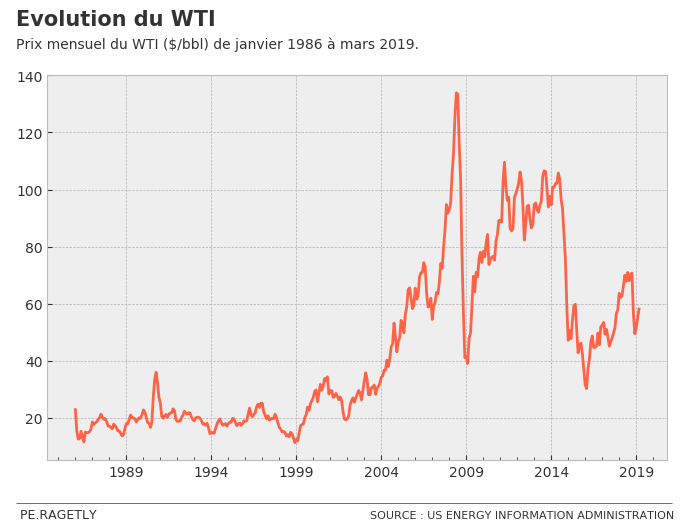

In [3]:
series_plot(df_price,
            colors=["tomato"],
            legend=False,
            source="US Energy Information Administration",
            title_s="Evolution du WTI",
            subtitle_s="Prix mensuel du WTI ($/bbl) de janvier 1986 à mars 2019.",
            file_s="Charts/WTI")

Le prix est plutôt stable dans les années 90, puis augmente à partir du début des années 2000 jusqu'à un pic en 2008. S'en suit une chute très brutale. Une telle chute ne peut être expliquée que par une crise mondiale majeure. Or, la date de 2008 correspond précisément à la faillite de la banque américaine *Lehman Brothers*, faillite entrainant le monde dans sa plus grave crise économique depuis 1929.  
(Cette chute est une anomalie, chercher à la modéliser entrainerait un surapprentissage du modèle.)

Les prix augmentent très fortement de 2009 à 2010, il s'agit là d'une correction de la chute de 2008. Les prix continuent à grimper de façon plus erratique jusque mi-2014, où apparait une forte chute. Cette chute est liée à la réponse de l'OPEP (L'Arabie Saoudite en tête) face à la forte montée en production des USA. Cette augmentation est liée à l'explosion du pétrole de schiste au Texas et dans le Dakota du Nord. Ces gisements non conventionnels sont plus coûteux à exploiter, l'OPEP a donc cherché à asphyxier financièrement les compagnies pétrolières américaines. Pour cela, les pays membres (ainsi que la Russie) ont augmenté massivement leur production entrainant la chute du baril. Cependant, les états membres de l'OPEP se sont fait prendre à leur propre jeu. Ayant des recettes provenant presque exclusivement du pétrole, certains états se sont retrouvés au bord de la faillite (L'Algérie et le Venezuela en tête). L'OPEP a dû revenir sur sa politique en imposant des quotas de production, ce qui a ralenti la chute des prix puis entraîner une nouvelle hausse.

**On constate que les cours de ces neufs dernières années (2010-2018) ont été grandement influencés par la production américaine. C'est donc tout naturellement que nous choisirons cette période pour l'entrainement de notre modèle.** 

## Première modélisation du prix par régression linéaire multiple

L'objectif est de modéliser le prix du WTI, il faudra donc utiliser des algorithmes de **régression**. Nous allons commencer par l'un des plus simples, la **régression linéaire multiple**. Si la relation n'est pas linéaire nous nous tournerons alors vers des algorithmes non linéaires type réseau de neurones.

### Choix des variables explicatives

Le prix d'un baril de pétrole est, comme tout bien de consommation, soumis à la loi du marché. Il dépend donc de l'offre et de la demande.  
Ainsi, nos deux premières variables explicatives seront :
- **la production**
- **la consommation**

De plus, le pétrole est une ressource stratégique. C'est pourquoi, les états ne pouvant se retrouver en pénurie, ils en stockent une partie. La variation de ces stocks va influencer le prix du baril. On obtient alors une troisième variable explicative :
- **les stocks**

Nous commençons par importer ces données et les incluont au jeu de données contenant le prix du WTI.

In [4]:
# On importe les trois variables
df_prod = (pd.read_csv("Data/Monthly US Oil Prod.csv", header=None,
                       names=["Date", "Oil_Prod (kbopd)"], skiprows=5, parse_dates=[0])
             .sort_values(by=["Date"])
             .assign(Month=lambda df: pd.date_range(df.Date.min(),
                                                     periods=df.shape[0],
                                                     freq="M"))
             .drop(columns="Date")
             .set_index("Month"))
df_demand = (pd.read_csv("Data/Weekly US Petroleum Product Supplied.csv", header=None,
                       names=["Month", "Oil_Demand (kbopd)"], skiprows=5, parse_dates=[0])
               .set_index("Month")
               .resample("M").mean())
df_stock = (pd.read_csv("Data/Monthly US Oil Stock (incl. SPR).csv", header=None,
                       names=["Date", "Oil_Stock (kbbls)"], skiprows=5, parse_dates=[0])
              .sort_values(by=["Date"])
              .assign(Month=lambda df: pd.date_range(df.Date.min(),
                                                     periods=df.shape[0],
                                                     freq="M"))
              .drop(columns="Date")
              .set_index("Month"))

# On les inclut au jeu de données
data = (pd.merge(df_price,df_prod, how="inner", on="Month")
          .merge(df_demand, how="inner", on="Month")
          .merge(df_stock, how="inner", on="Month"))

# On vérifie la qualité des données
data.describe()

,WTI_Price ($/bbl),Oil_Prod (kbopd),Oil_Demand (kbopd),Oil_Stock (kbbls)
count,169.000000,169.000000,169.000000,1.690000e+02
mean,72.961124,7036.905325,19796.107396,1.059808e+06
std,22.140222,2050.075638,881.108330,6.313497e+04
min,30.320000,3974.000000,18162.600000,9.499840e+05
25%,54.190000,5211.000000,19030.500000,1.011152e+06
50%,70.750000,6161.000000,19759.500000,1.045277e+06
75%,92.970000,9041.000000,20499.500000,1.084477e+06
max,133.880000,11961.000000,21796.750000,1.230105e+06


On constate :
- l'absence de données manquantes ;
- l'absence de données atypiques (même ordre de grandeur entre le min et le max) ;
- une homogénéité des unités.

Les données sont de bonne qualité, aucune correction n'est donc nécessaire.

### Préparation des données

Avant de commencer à entraîner l'algorithme de régression, il est nécessaire de préparer les données en effectuant une standardisation. La méthode `StandardScaler()` de *Scikitlearn* a été utilisée.
$$x_{new}=\frac{x_{old}-\mu}{\sigma}$$

In [5]:
# On stocke les données dans une matrice et un vecteur
X = data.loc["31/01/2010":, "Oil_Prod (kbopd)":].values
y = data.loc["31/01/2010":, "WTI_Price ($/bbl)"].values

# On applique la méthode de standardisation
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

### Premiers résultats

In [6]:
# Utilisation d'une constante
endog = pd.DataFrame(y, columns=data.columns.tolist()[:1])
exog = pd.DataFrame(X_scaled, columns=data.columns.tolist()[1:])
intercept = sm.add_constant(exog)
base_model = sm.OLS(endog, intercept)
baseline = base_model.fit()
baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      WTI_Price ($/bbl)   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     145.8
Date:                Thu, 02 May 2019   Prob (F-statistic):           2.69e-37
Time:                        10:49:44   Log-Likelihood:                -403.68
No. Observations:                 109   AIC:                             815.4
Df Residuals:                     105   BIC:                             826.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 73.9245      0.958     77.129      0.000      72.024      75.825
Oil_Prod (kbopd)      -1.9128      1.383     -1.383      0.170      -4.655       0.830
Oil_Demand (kbopd)    -6.2098      1.390     -4.466      0.000      -8.967      -3.453
Oil_Stock (kbbls)    -15.0034      1.123    -13.360      0.000     -17.230     -12.777
==============================================================================
Omnibus:                        0.558   Durbin-Watson:                   0.393
Prob(Omnibus):                  0.757   Jarque-Bera (JB):                0.674
Skew:                          -0.155   Prob(JB):                        0.714
Kurtosis:                       2.770   Cond. No.                         2.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Les résultats sont plutôt encourageants, même si la variable production semble ne pas être significative.  
Plusieurs raisons pourraient expliquer la non-significativité de la production :
- Une relation non linéaire entre l'endogène et les exogènes (peu vraisemblable compte tenu du $R^2$)
- Une colinéarité entre les exogènes
- La production prise telle quelle n'est pas significative

Commençons par vérifier les 2 premiers points.

### Vérification de la linéarité

Commençons par vérifier si les relations entre les exogènes (variables explicatives) et l'endogène (variable à expliquer) sont bien linéaires. Dans le cas contraire, il faudra opter pour des algorithmes non linéaire type réseau de neurones.  
Tracer les résidus en fonction des valeurs prédites permet facilement de vérifier la linéarité des relations

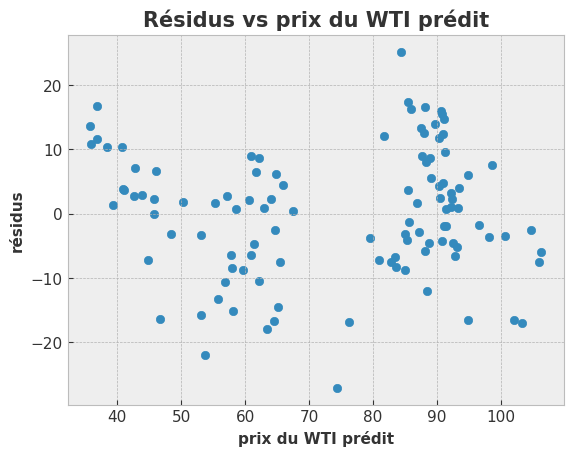

In [7]:
# On récupère les résidus et les valeurs prédites
y_pred = baseline.predict()
res = baseline.resid
var = "prix du WTI prédit"

# On trace le graphique
(fig, ax) = plt.subplots(1, 1)
ax.scatter(y_pred, res)
ax.tick_params(axis="both", which="both", colors="#333333", labelsize=11)
ax.set_xlabel(var, weight="bold", color="#333333", fontsize=11)  
ax.set_ylabel("résidus", weight="bold", color="#333333", fontsize=11)
ax.set_title("Résidus vs {}".format(var), loc="center",
             color="#333333", weight="bold", fontsize=15)
plt.savefig("Charts/fitWTI_res.png", bbox_inches = "tight")
plt.show()

On obtient bien un nuage de points symétriques par rapport à 0, **confirmant la linéarité de la relation.**

### Vérification de l'indépendance des exogènes

In [8]:
mc = np.corrcoef(X_scaled, rowvar=False)
mc_inv = np.linalg.inv(mc)
vif = np.diag(mc_inv)
print(vif)

[2.08256877 2.10431018 1.37280597]


Les VIF sont nettement inférieurs à 10, on peut donc rejeter l'hypothèse de colinéarité entre les variables.  
La production prise telle quelle n'est donc pas significative, vérifions si l'on peut la modifier pour la rendre plus significative.

## Modification des exogènes

### Modification de la variable production

On peut se dire que le prix va être plus sensible aux variations de la production qu'à la production elle même. Différentions cette dernière en effectuant l'opération suivante :
$$Prod\_Diff = Prod_{t} - Prod_{t-i}$$

Nous testerons différents retards (i variant de 0 à 12) en vérifiant leurs siginificativité à l'aide de la méthode récursive `sklearn.feature_selection.RFE`. Pour éviter de prendre en compte la correction de 2009 qui est fait suite à la forte chute de 2008, nous utiliserons que les données post janvier 2011. 

In [9]:
# Création des différenciation
df = data.loc[:, :"Oil_Prod (kbopd)"].copy()
for i in range(1,13):
    df["lag " + str(i)] = df["Oil_Prod (kbopd)"].diff(i)
df = df.loc["31/01/2011":, :]
# Sélection de la différenciation
X = df.iloc[:, -13:].values
y = df.iloc[:, :1].values.ravel() # transform a column-vector into a 1d array
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
estimator = linear_model.LinearRegression()
selector = feature_selection.RFE(estimator, 1, step=1)
selector = selector.fit(X_scaled, y)
for i in range(13):
    print("rang dif {} : {}".format(i, selector.ranking_[i]))

rang dif 0 : 1
rang dif 1 : 13
rang dif 2 : 11
rang dif 3 : 12
rang dif 4 : 4
rang dif 5 : 8
rang dif 6 : 7
rang dif 7 : 10
rang dif 8 : 9
rang dif 9 : 3
rang dif 10 : 5
rang dif 11 : 6
rang dif 12 : 2


On constate que les meilleurs résultats sont obtenus quand **la production n'est pas différenciée.**

Testons une nouvelle hypothèse ; le marché réagit rarement de manière instantanée à toute hausse (ou baisse) de la production. Il est donc fort probable qu'il y ait un effet de latence entre la production et le prix. Vérifions cette hypothèse, toujours à l'aide de la fonction `sklearn.feature_selection.RFE` en faisant varier le retard de 0 à 12.

In [10]:
# Création des retards
df = data.loc[:, :"Oil_Prod (kbopd)"].copy()
for i in range(1,13):
    df["lag " + str(i)] = df["Oil_Prod (kbopd)"].shift(i)
df = df.loc["31/01/2011":, :]

# Sélection du retard
X = df.iloc[:, -13:].values
y = df.iloc[:, :1].values.ravel() # transform a column-vector into a 1d array
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
estimator = linear_model.LinearRegression()
selector = feature_selection.RFE(estimator, 1, step=1)
selector = selector.fit(X_scaled, y)
for i in range(13):
    print("rang lag {} : {}".format(i, selector.ranking_[i]))

rang lag 0 : 2
rang lag 1 : 12
rang lag 2 : 11
rang lag 3 : 13
rang lag 4 : 3
rang lag 5 : 6
rang lag 6 : 5
rang lag 7 : 10
rang lag 8 : 9
rang lag 9 : 4
rang lag 10 : 8
rang lag 11 : 7
rang lag 12 : 1


On observe que de meilleurs résultats sont obtenus en intégrant un retard de 12 mois à la production. Ajoutons donc cette variable modifiée au jeu de données. De plus, on vérifiera si des transformations similaires peuvent être appliquées sur les autres variables explicatives.

In [11]:
data["Prod_lag12"] = data["Oil_Prod (kbopd)"].shift(12)

### Modification de la variable demande

In [12]:
# Création des différenciation
df = data.loc[:, :"Oil_Demand (kbopd)"].copy()
for i in range(1,13):
    df["lag " + str(i)] = df["Oil_Demand (kbopd)"].diff(i)
df = df.loc["31/01/2011":, :]
# Sélection de la différenciation
X = df.iloc[:, -13:].values
y = df.iloc[:, :1].values.ravel() # transform a column-vector into a 1d array
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
estimator = linear_model.LinearRegression()
selector = feature_selection.RFE(estimator, 1, step=1)
selector = selector.fit(X_scaled, y)
for i in range(13):
    print("rang dif {} : {}".format(i, selector.ranking_[i]))

rang dif 0 : 1
rang dif 1 : 6
rang dif 2 : 3
rang dif 3 : 4
rang dif 4 : 8
rang dif 5 : 2
rang dif 6 : 5
rang dif 7 : 7
rang dif 8 : 9
rang dif 9 : 13
rang dif 10 : 12
rang dif 11 : 11
rang dif 12 : 10


On constate que les meilleurs résultats sont obtenus quand **la consommation n'est pas différenciée.**

Comme pour la production, nous allons vérifier s'il y a un effet de latence entre la variation de la demande et la variation du prix.

In [13]:
# Création des retards
df = data.loc[:, :"Oil_Demand (kbopd)"].copy()
for i in range(1,13):
    df["lag " + str(i)] = df["Oil_Demand (kbopd)"].shift(i)
df = df.loc["31/01/2011":, :]

# Sélection du retard
X = df.iloc[:, -13:].values
y = df.iloc[:, :1].values.ravel() # transform a column-vector into a 1d array
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
estimator = linear_model.LinearRegression()
selector = feature_selection.RFE(estimator, 1, step=1)
selector = selector.fit(X_scaled, y)
for i in range(13):
    print("rang lag {} : {}".format(i, selector.ranking_[i]))

rang lag 0 : 1
rang lag 1 : 3
rang lag 2 : 5
rang lag 3 : 2
rang lag 4 : 7
rang lag 5 : 6
rang lag 6 : 4
rang lag 7 : 8
rang lag 8 : 9
rang lag 9 : 13
rang lag 10 : 12
rang lag 11 : 11
rang lag 12 : 10


On constate que, contrairement à la production, les meilleurs résultats sont obtenus quand on n'intègre pas de retard. Nous ne modifierons donc pas cette variable.
Passons aux stocks.

### Modification de la variable Stock

In [14]:
# Création des différenciation
df = data.loc[:, :"Oil_Stock (kbbls)"].copy()
for i in range(1,13):
    df["lag " + str(i)] = df["Oil_Stock (kbbls)"].diff(i)
df = df.loc["31/01/2011":, :]
# Sélection de la différenciation
X = df.iloc[:, -13:].values
y = df.iloc[:, :1].values.ravel() # transform a column-vector into a 1d array
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
estimator = linear_model.LinearRegression()
selector = feature_selection.RFE(estimator, 1, step=1)
selector = selector.fit(X_scaled, y)
for i in range(13):
    print("rang dif {} : {}".format(i, selector.ranking_[i]))

rang dif 0 : 1
rang dif 1 : 6
rang dif 2 : 13
rang dif 3 : 5
rang dif 4 : 10
rang dif 5 : 12
rang dif 6 : 9
rang dif 7 : 8
rang dif 8 : 2
rang dif 9 : 4
rang dif 10 : 11
rang dif 11 : 3
rang dif 12 : 7


On constate que les meilleurs résultats sont obtenus quand **les stocks ne sont pas différenciés.**

Là encore, nous allons vérifier s'il y a un effet de latence avec le prix.

In [15]:
# Création des retards
df = data.loc[:, :"Oil_Stock (kbbls)"].copy()
for i in range(1,13):
    df["lag " + str(i)] = df["Oil_Stock (kbbls)"].shift(i)
df = df.loc["31/01/2011":, :]

# Sélection du retard
X = df.iloc[:, -13:].values
y = df.iloc[:, :1].values.ravel() # transform a column-vector into a 1d array
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
estimator = linear_model.LinearRegression()
selector = feature_selection.RFE(estimator, 1, step=1)
selector = selector.fit(X_scaled, y)
for i in range(13):
    print("rang lag {} : {}".format(i, selector.ranking_[i]))

rang lag 0 : 1
rang lag 1 : 2
rang lag 2 : 13
rang lag 3 : 3
rang lag 4 : 7
rang lag 5 : 12
rang lag 6 : 9
rang lag 7 : 8
rang lag 8 : 4
rang lag 9 : 6
rang lag 10 : 11
rang lag 11 : 5
rang lag 12 : 10


Comme la consommation, il est préférable de ne pas intégrer de retard pour les stock.

## Nouvelle régression linéaire multiple avec la production décalée de 12 mois

Effectuons une régression en intégrant cette fois la production retardée de 12 mois au lieu de la production standard.

In [16]:
# Standardisation des données
X = data.loc["31/01/2011":, "Oil_Demand (kbopd)":].values
y = data.loc["31/01/2011":, "WTI_Price ($/bbl)"].values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Entrainement du modèle
endog = pd.DataFrame(y, columns=data.columns.tolist()[:1])
exog = pd.DataFrame(X_scaled, columns=data.columns.tolist()[2:])
intercept = sm.add_constant(exog)
model = sm.OLS(endog, intercept)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      WTI_Price ($/bbl)   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     156.7
Date:                Thu, 02 May 2019   Prob (F-statistic):           3.07e-36
Time:                        10:49:44   Log-Likelihood:                -356.62
No. Observations:                  97   AIC:                             721.2
Df Residuals:                      93   BIC:                             731.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 73.2477      0.991     73.892      0.000      71.279      75.216
Oil_Demand (kbopd)    -3.6894      1.630     -2.263      0.026      -6.927      -0.452
Oil_Stock (kbbls)    -12.3380      1.543     -7.996      0.000     -15.402      -9.274
Prod_lag12            -7.8538      2.156     -3.643      0.000     -12.134      -3.573
==============================================================================
Omnibus:                        2.164   Durbin-Watson:                   0.363
Prob(Omnibus):                  0.339   Jarque-Bera (JB):                2.102
Skew:                          -0.289   Prob(JB):                        0.350
Kurtosis:                       2.569   Cond. No.                         4.20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Cette fois, toutes les variables sont significatives**.  
A noter aussi que le test de Jarque-Bera valide l'hypothèse de normalité des résidus. Vérifions maintenant les autres hypothèses :
- homoscédasticité des résidus ;
- absence de corrélation entre les exogènes.

### Analyse des résidus et vérification de l'indépendance des exogènes

Comme dit précédemment, le test de **Jarque-Bera** a montré que les résidus suivaient bien une distribution normale. Vérifions maintenant l'hypothèse d'homoscédasticité à l'aide du **test de Breusch-Pagan**.

In [17]:
res = results.resid
stat, p = sm.stats.het_breuschpagan(res, exog)[2:]
print("la p-valeur est {:.2%}".format(p))

la p-valeur est 62.64%


Le test valide l'homoscédasticité des résidus.

Vérifions maintenant les corrélations entre exogènes en calculant les facteurs d'influence de la variance noté VIF (*Variance Inflation Factor*). Ces facteurs peuvent être lus sur la diagonale de la matrice des corrélations inversée.

In [18]:
mc = np.corrcoef(X_scaled, rowvar=False)
mc_inv = np.linalg.inv(mc)
vif = np.diag(mc_inv)
print(vif)

[2.70492    2.42287018 4.7287704 ]


Les VIF sont inférieurs à 10, on peut donc rejeter l'hypothèse d'une forte colinéarité entre les variables. Cependant, n'étant pas négligeables, il se peut qu'il y ait quand même une corrélation. On verra comment régler ce problème avec la **régularisation**. De plus, on pourra se servir de cette corrélation lorqu'il faudra prédire les stocks ou la consommation.

### Régularisation

Nous avons vu qu'il existait une relation non négligeable entre la production retardée et les stocks. Or, lorsque les variables **sont corrélées**, la solution n'est pas unique et les coefficients ont une grande variabilité. Cet inconvénient entraine un risque de **sur-apprentissage**, i.e. que le modèle colle trop aux données d'entraînement.  
Pour limiter ce risque, on peut utiliser ce qu'on appelle la technique de **régularisation**. Cette technique consiste à contrôler simultanément l'erreur du modèle sur le jeu d'entrainement et la **complexité du modèle**. Comme plus un modèle est complexe plus le risque de sur-apprentissage est élevé, limiter la complexité du modèle revient à limiter le risque de sur-apprentissage. Ainsi, nous ne chercherons plus à minimiser seulement la somme des carrés des erreurs &ndash; **méthode des moindres carrés** &ndash; mais, à minimiser cette somme plus un terme mesurant la complexité :
$$min_{\beta \in \mathbb{R}^{p+1}}\left((y-X\beta)^\top (y-X\beta) + \alpha \times Regularisateur(\beta) \right)$$
- Le coefficient de **régularisation** $\alpha$, est un **hyperparamètre** toujours **positif** qui contrôle l'importance relative du terme d'erreur et du terme de régularisation. S'il est égal à 0, cela revient à faire une régularisation Linéaire classique &ndash; non régularisée.
- Le **Régularisateur**, qui mesure la complexité du modèle, est une fonction des poids $\beta$ du modèle. Les plus utilisés sont :
    - La norme $\ell_2$ ou **norme euclidienne** (**régression ridge**) qui permet de restreindre l'amplitude des poids et d'avoir des coefficients similaires pour les variables corrélées.
    - La norme $\ell_1$ (**méthode du lasso** &ndash; Least Absolute Shrinkage and Selection Operator) qui permet d'avoir un modèle **parcimonieux**, i.e. un modèle avec des coefficients nuls pour les variables non significatives.

Ici, nous avons seulement trois variables explicatives, le modèle est donc déjà parcimonieux. Nous allons donc **privilégier la régression ridge à celle du Lasso**.

On appelle **hyperparamètre** tout paramètre qui ne va pas être trouvé par l'algorithme d'apprentissage mais imposé par l'utilisateur. Pour trouver l'hyperparamètre optimal nous effectuerons une **validation croisée** sur le training set. Cette technique permet d'utiliser l'intégralité du jeu d'entrainement, donc sans avoir à en préserver une partie dédiée à la validation du modèle. 
Pour ce faire, nous allons découper le jeu d'entrainement en k parties à peu près égales. Tour à tour, chacune des k parties est utilisée comme jeu de validation ; le reste &ndash; les k-1 autres parties &ndash; est utilisé pour l'entraînement.  
Pour effectuer la validation croisée nous utiliserons la méthode `linear_model.RidgeCV` de Scikit-Learn.

In [19]:
# On standardise et sépare les données
X = data.loc["31/01/2011":, "Oil_Demand (kbopd)":].values
y = data.loc["31/01/2011":, "WTI_Price ($/bbl)"].values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y, test_size=0.1)

# On affiche le résultats sans régularisation
lin_reg = linear_model.LinearRegression()
model = lin_reg.fit(X_train, y_train)
print("Sans régularisation :\nR2 = {:.3}".format(model.score(X_test, y_test)))

# On affiche le résultats avec régularisation
model_ridge = linear_model.RidgeCV()
model_ridge.fit(X_train, y_train)
print("Meilleur paramètre : alpha = {}".format(model_ridge.alpha_))
print("Avec régularisation :\nR2 = {:.3}".format(model_ridge.score(X_test, y_test)))

Sans régularisation :
R2 = 0.723
Meilleur paramètre : alpha = 1.0
Avec régularisation :
R2 = 0.725


La régularisation n'améliore pas le modèle, ce qui indique que les corrélations entre les variables ne sont pas significatives. Pour la suite nous utiliserons un modèle non régularisé.

### Visualisation des résultats

Nous allons entraîner le modèle sur la totalité du jeu de données nous visualiserons ensuite les résultats du modèle par rapport aux données réelles.

Résultat du modèle : R2 = 0.835


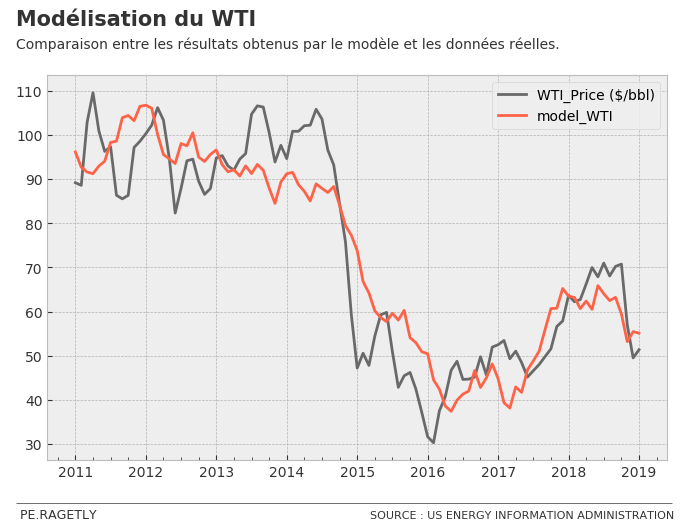

In [20]:
# entrainement du modèle et récupération des résultats
lin_reg = linear_model.LinearRegression()
model = lin_reg.fit(X_scaled, y)
y_pred = model.predict(X_scaled)
print("Résultat du modèle : R2 = {:.3}".format(model.score(X_scaled, y)))

# Visualisation des résultats
df = data.loc["31/01/2011":, :].copy()
df.loc[:,"model_WTI"] = y_pred
series_plot(df[["WTI_Price ($/bbl)", "model_WTI"]],
            colors=["dimgrey", "tomato"],
            source="US Energy Information Administration",
            title_s="Modélisation du WTI",
            subtitle_s="Comparaison entre les résultats obtenus par le modèle et les données réelles.",
            file_s="Charts/model_results")

## Prédiction du prix du WTI

Pour prédire le WTI, nous allons d'abord prédire les trois variables explicatives :
- Production retardée
- Demande
- Stock

Puis nous utiliserons le modèle choisi précédemment sur les variables prédites pour avoir la prédiction du prix.

Vu que la production retardée est la production réelle décalée de 12 mois, il n'est pas nécessaire (a priori) de prédire cette variable.  
En revanche il va nous falloir prédire la demande les stocks.


### Prédiction des Stocks

Nous allons tenter de prédire les stocks, pour cela nous utiliserons un SARIMA

#### Analyse de la tendance et de la saisonnalité

Commençons par analyser les données.

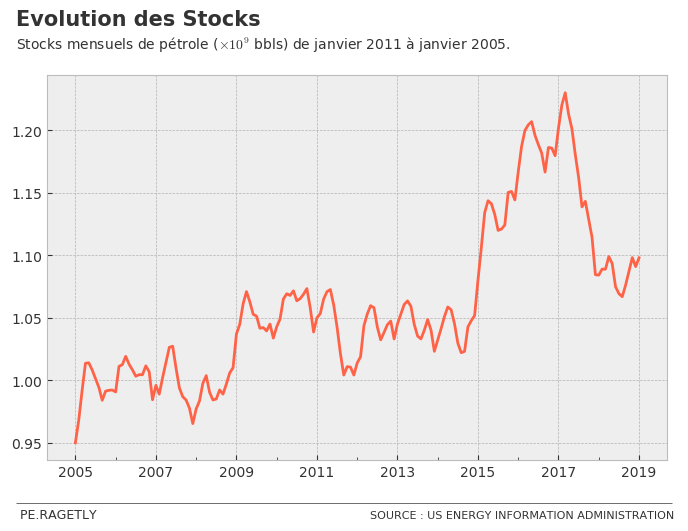

In [21]:
series_plot(data["Oil_Stock (kbbls)"]/1000000,
            colors=["tomato"],
            legend=False,
            source="US Energy Information Administration",
            title_s="Evolution des Stocks",
            subtitle_s=r"Stocks mensuels de pétrole ($\times10^{9}$ bbls) de janvier 2011 à janvier 2005.",
            file_s="Charts/Stocks")

Les variations ne semblent pas croître ou décroître en fonction du temps, nous utiliserons donc un modèle de type additif.  
Pour vérifier l'existence d'une tendance et/ou saisonnalité, nous utiliserons la méthode `seasonal_decompose()` de la librairie *statsmodels* basée sur l'utilisation des moyennes mobiles.

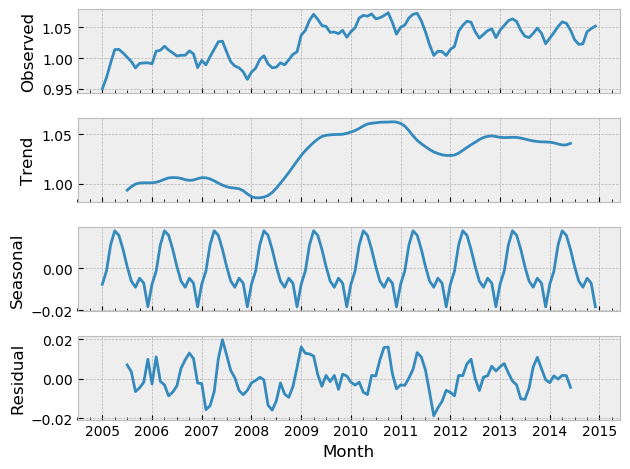

In [22]:
decomp_stock = seasonal_decompose(data["Oil_Stock (kbbls)"][:"31/12/14"]/1000000,
                                  model="additive")
decomp_stock.plot()
plt.savefig("Charts/Stock_decomp.png", bbox_inches = "tight")
plt.show()

La présence d'une tendance n'est pas évidente. De plus, l'algorithme nous a trouvé une saisonnalité d'ordre 12.  
A noter que sur des données mensuelles, l'algorithme utilisé ne va tester automatiquement que des saisonnalités trimestrielles (freq=3), semestrielles (freq=6) et annuelles (freq=12). Pour tester d'autres saisonnalités, il faudra les rentrer manuellement via le paramatétre *freq*. Au vu des données, une saisonnalité annuelle semble être un bon point de départ. Nous vérifierons ce point lors de l'étude des autocorrélations. 

#### Analyse des fonction d'autocorrélations

Nous entrainerons le modèle sur le jeu de données tronqué des données postérieures à 2017 (13 derniers mois), et comparerons ses résultats avec les données réelles.

In [23]:
stock = data["Oil_Stock (kbbls)"]
y_train = stock[:"31/12/14"]

Les processus AR ne s'appliquant que sur des processus centrés, nous allons commencer par centrer les données

In [24]:
mu_train = y_train.mean()
y_train -= mu_train

Analysons la fonction des auto-corrélations (ACF) pour vérifier s'il est nécessaire de différencier &ndash; présence de tendance et/ou de saisonnalité.

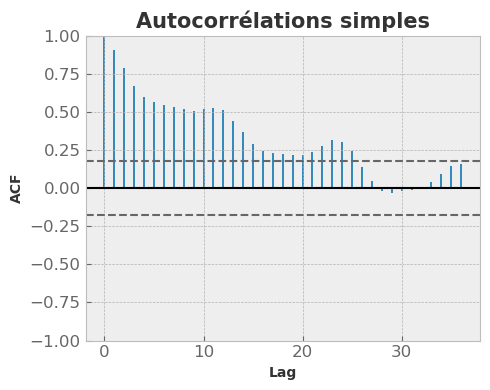

In [25]:
acf_plot(y_train, nlags=36, partial=False, unbiased=True)

La décroissance est lente, on différencie une 1ère fois

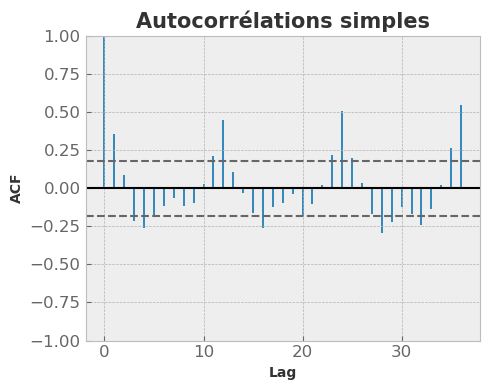

In [26]:
acf_plot(y_train.diff().dropna(), nlags=36, partial=False, unbiased=True)

La présence de fortes autocorrélations pour les décalages d'ordre 12 suggère une saisonnalité annuelle. Ce qui avait aussi été observé lors de l'étude de la saisonnalité. Nous allons donc effectuer une différenciation d'ordre 12 et analyser une nouvelle fois les corrélogrammes.

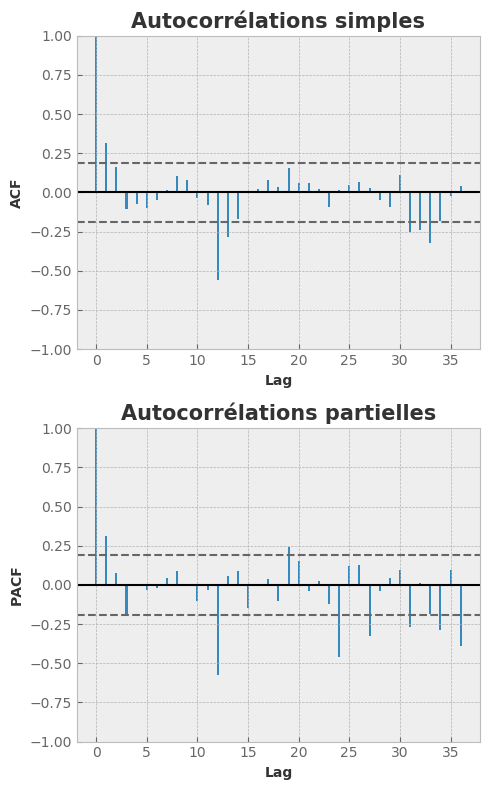

In [27]:
acf_plot(y_train.diff().diff(12).dropna(), nlags=36, partial=True, unbiased=True)

Nous avons maintenant bien une décroissance rapide ainsi qu'une absence de pics répétés, nous allons pouvoir déterminer les paramètres du SARIMA. Avant toute chose nous devons rappeler que pour pouvoir être prédictif, un modèle doit rester simple. Dans le cas contraire, il collera trop aux données et aura donc un faible pouvoir prédictif. Pour ne pas tomber dans le piège du surapprentissage nous suivrons les deux règles suivantes :
>*Dans la grande majorité des cas p = 0 ou q = 0, et p+q est inférieur ou égale à 3* (Duke, Prof. Robert Nau).
  
>*P, Q = {0,1}*
  
Après analyse des corrélations nous obtenons les résultats suivants :
- p = 1 : parmi les 3 premiers lags du PACF seul le premier est significatif
- q = 1 : parmi les 3 premiers lags de l'ACF seul le premier est significatif
- P = 1 : le douzième lag du PACF est significatif
- Q = 1 : le douzième lag de l'ACF est significatif

Nous obtenons donc le modèle suivant, **SARIMA(1,1,1)(1,1,1,12)**.  
Vérifions la siginificativité de chaque paramètre et la blancheur des résidus.

#### Vérification des hypothèses

In [28]:
sarima = SARIMAX(np.asarray(y_train), order=(1,1,1), seasonal_order=(1,1,1,12))
sarima = sarima.fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1129.654
Date:                            Thu, 02 May 2019   AIC                           2269.308
Time:                                    10:49:50   BIC                           2282.672
Sample:                                         0   HQIC                          2274.725
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2966      0.590      0.502      0.615      -0.861       1.454
ma.L1         -0.1498      0.600     -0.250      0.803      -1.325       1.026
ar.S.L12       0.2286      0.123      1.864      0.062      -0.012       0.469
ma.S.L12      -0.7542      0.175     -4.315      0.000      -1.097      -0.412
sigma2       1.07e+08   6.91e-09   1.55e+16      0.000    1.07e+08    1.07e+08
===================================================================================
Ljung-Box (Q):                       31.40   Jarque-Bera (JB):                 5.00
Prob(Q):                              0.83   Prob(JB):                         0.08
Heteroskedasticity (H):               0.31   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.84e+31. Standard errors may be unstable.
"""

Le paramètre MA n'est pas significatif, testons avec q=0

In [29]:
sarima = SARIMAX(np.asarray(y_train), order=(1,1,0), seasonal_order=(1,1,1,12))
sarima = sarima.fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -1130.065
Date:                            Thu, 02 May 2019   AIC                           2268.130
Time:                                    10:49:50   BIC                           2278.821
Sample:                                         0   HQIC                          2272.464
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1473      0.112      1.319      0.187      -0.072       0.366
ar.S.L12       0.2300      0.128      1.803      0.071      -0.020       0.480
ma.S.L12      -0.7512      0.180     -4.167      0.000      -1.104      -0.398
sigma2      1.098e+08   9.02e-10   1.22e+17      0.000     1.1e+08     1.1e+08
===================================================================================
Ljung-Box (Q):                       32.46   Jarque-Bera (JB):                 5.16
Prob(Q):                              0.80   Prob(JB):                         0.08
Heteroskedasticity (H):               0.31   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.18e+33. Standard errors may be unstable.
"""

Le paramètre AR n'est pas significatif, testons avec p=0

In [30]:
sarima = SARIMAX(np.asarray(y_train), order=(0,1,0), seasonal_order=(1,1,1,12))
sarima = sarima.fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -1129.443
Date:                            Thu, 02 May 2019   AIC                           2264.886
Time:                                    10:49:51   BIC                           2272.905
Sample:                                         0   HQIC                          2268.137
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.2999      0.067      4.453      0.000       0.168       0.432
ma.S.L12      -1.0000      0.132     -7.547      0.000      -1.260      -0.740
sigma2      7.366e+07    1.8e-09    4.1e+16      0.000    7.37e+07    7.37e+07
===================================================================================
Ljung-Box (Q):                       38.62   Jarque-Bera (JB):                 0.99
Prob(Q):                              0.53   Prob(JB):                         0.61
Heteroskedasticity (H):               0.38   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.02e+32. Standard errors may be unstable.
"""

Nous constatons que pour une confiance de test de 5% :
- Tous les paramètres sont significatifs ;
- L'absence d'autocorrélation entre résidus est vérifiée (test Ljung-Box, pvalue = 1)
- L'homoscédasticité des résidus est vérifiée (pvalue = 0.31)

En revanche les résidus ne suivent pas une distribution normale, le bruit blanc n'est donc pas gaussien.

**Toutes les hypothèses sont vérifiées, on valide le modèle SARIMA(0,1,0)(1,1,1,12)**.

#### Visualisation de la prédiction des stocks

Comme les données de jan-15 à dec-17 n'ont pas été inclues, il va falloir décaler un peu nos prédiction pour être en ligne avec la dernière valeur des stock (dec-17). 

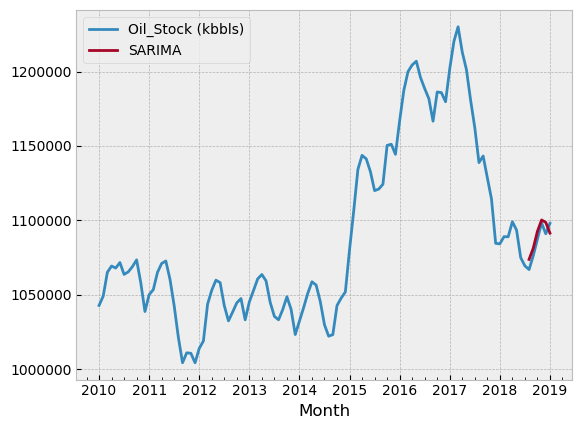

In [31]:
# Récupération des prévisions
pred_stock = sarima.forecast(6)
pred_stock += mu_train

# Décalage des prévisions
shift = data.loc["31/07/18","Oil_Stock (kbbls)"] - data.loc["31/12/14","Oil_Stock (kbbls)"]
pred_stock += shift

# On ajoute les prédictions aux données
df_model = data.copy()
index = df_model["Oil_Stock (kbbls)"].index[-6:]
df_model.loc[index, "SARIMA"] = np.around(pred_stock, 2)

df_model.loc["31/01/10":].plot(y=["Oil_Stock (kbbls)", "SARIMA"])
plt.savefig("Charts/Stock_SARIMA.png", bbox_inches = 'tight')
plt.show()

On constate que la prédiction est correcte sur 6 mois, nous utiliserons donc une prériode de 6 mois pour tester notre modèle finale.

### Prédiction des Consommations

Nous allons tenter de prédire les stocks, pour cela nous utiliserons un SARIMA

#### Analyse de la tendance et de la saisonnalité

Commençons par analyser les données.

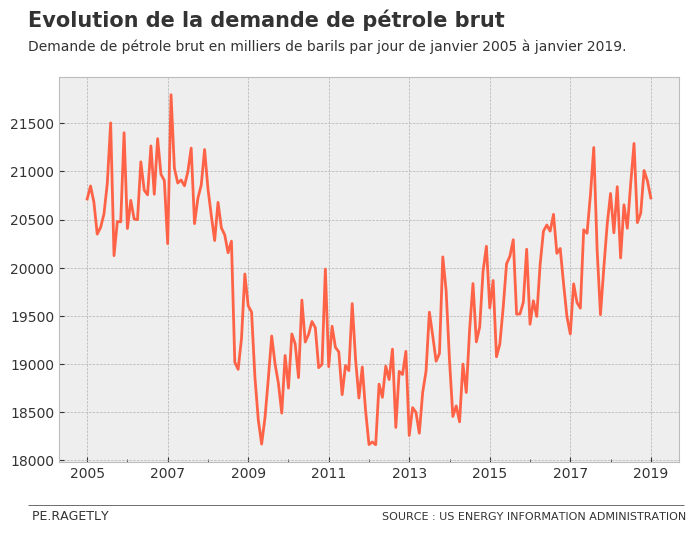

In [32]:
series_plot(data["Oil_Demand (kbopd)"],
            colors=["tomato"],
            legend=False,
            source="US Energy Information Administration",
            title_s="Evolution de la demande de pétrole brut",
            subtitle_s=r"Demande de pétrole brut en milliers de barils par jour de janvier 2005 à janvier 2019.",
            file_s="Charts/Demand")

Les variations ne semblent pas croître ou décroître en fonction du temps, nous utiliserons donc un modèle de type additif.  
Pour vérifier l'existance d'une tendance et/ou saisonnalité, nous utiliserons la méthode `seasonal_decompose()` de la librairie *statsmodels* basée sur l'utilisation des moyennes mobiles.

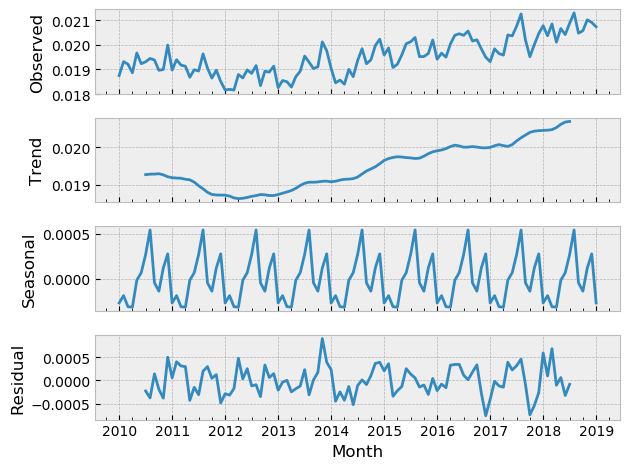

In [33]:
decomp_stock = seasonal_decompose(data["Oil_Demand (kbopd)"]["31/01/10":]/1000000,
                                  model="additive")
decomp_stock.plot()
plt.savefig("Charts/Stock_decomp.png", bbox_inches = "tight")
plt.show()

On constate la présence d'une tendance. L'algorithme nous a trouvé une saisonnalité d'ordre 12.

#### Analyse des fonction d'autocorrélations

Nous entrainerons le modèle sur le jeu de données tronqué des données postérieures à 2017 (13 derniers mois), et comparerons ses résultats avec les données réelles.

In [34]:
conso = data["Oil_Demand (kbopd)"]
y_train = conso["31/01/10": "31/07/18"]
y_train = np.log(y_train)

Les processus AR ne s'appliquant que sur des processus centrés, nous allons commencer par centrer les données

In [35]:
mu_train = y_train.mean()
y_train = y_train - mu_train

Analysons la fonction des auto-corrélations.

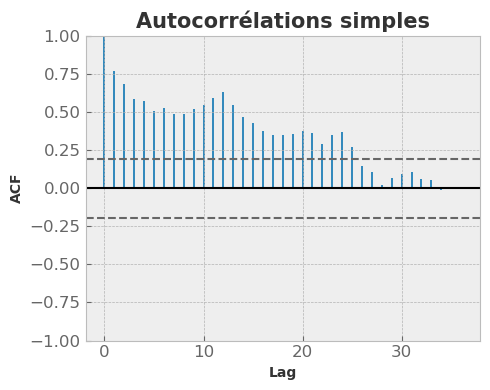

In [36]:
acf_plot(y_train.dropna(), nlags=36, partial=False, unbiased=True)

La décroissance est lente, on différencie une 1ère fois

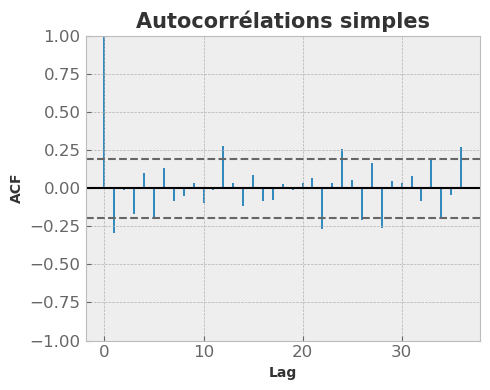

In [37]:
acf_plot(y_train.diff().dropna(), nlags=36, partial=False, unbiased=True)

La présence de fortes autocorrélations pour les décalages d'ordre 12 suggère une saisonnalité annuelle. Ce qui avait aussi été observé lors de l'étude de la saisonnalité. Nous allons donc effectuer une différenciation d'ordre 12 et analyser une nouvelle fois les corrélogrammes.

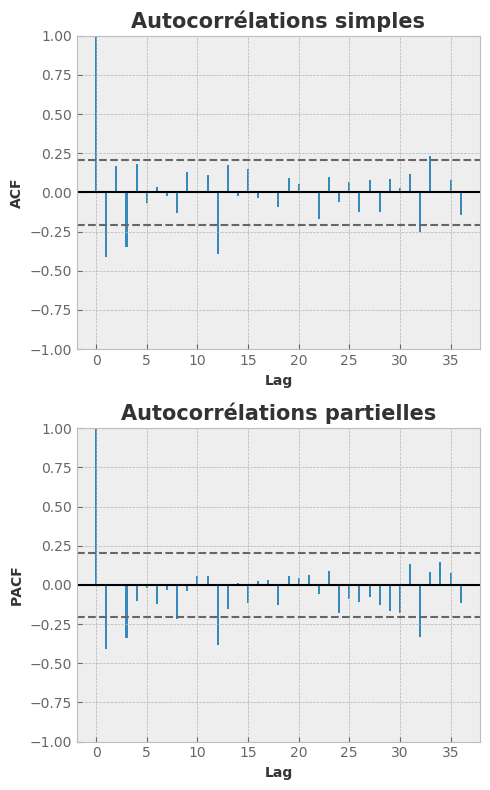

In [38]:
acf_plot(y_train.diff().diff(12).dropna(), nlags=36, partial=True, unbiased=True)

Nous avons maintenant bien une décroissance rapide ainsi qu'une absence de pics répétés, nous allons pouvoir déterminer les paramètres du SARIMA. Avant toute chose nous devons rappeler que pour pouvoir être prédictif, un modèle doit rester simple. Dans le cas contraire, il collera trop aux données et aura donc un faible pouvoir prédictif. Pour ne pas tomber dans le piège du surapprentissage nous suivrons les deux règles suivantes :
>*Dans la grande majorité des cas p = 0 ou q = 0, et p+q est inférieur ou égale à 3* (Duke, Prof. Robert Nau).
  
>*P, Q = {0,1}*
  
Après analyse des corrélations nous obtenons les résultats suivants :
- p = 3 : les 3 premiers lags du PACF sont significatifs
- q = 3 : les 3 premiers lags de l'ACF sont significatifs
- P = 1 : le douzième lag du PACF est significatif
- Q = 1 : le douzième lag de l'ACF est significatif

Nous obtenons donc le modèle suivant, **SARIMA(3,1,3)(1,1,1,12)**.  
Vérifions la siginificativité de chaque paramètre et la blancheur des résidus.

#### Vérification des hypothèses

In [39]:
sarima = SARIMAX(np.asarray(y_train), order=(3,1,3), seasonal_order=(1,1,1,12))
sarima = sarima.fit()
sarima.summary()

C:\Users\pe.ragettli\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  103
Model:             SARIMAX(3, 1, 3)x(1, 1, 1, 12)   Log Likelihood                 224.839
Date:                            Thu, 02 May 2019   AIC                           -431.678
Time:                                    10:49:59   BIC                           -409.180
Sample:                                         0   HQIC                          -422.605
                                            - 103                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5294      0.531     -0.997      0.319      -1.570       0.511
ar.L2          0.1968      0.381      0.517      0.605      -0.549       0.943
ar.L3          0.0826      0.394      0.210      0.834      -0.689       0.854
ma.L1          0.1134      0.525      0.216      0.829      -0.916       1.143
ma.L2         -0.4278      0.310     -1.381      0.167      -1.035       0.179
ma.L3         -0.3813      0.418     -0.912      0.362      -1.201       0.438
ar.S.L12      -0.0177      0.220     -0.080      0.936      -0.449       0.413
ma.S.L12      -0.7297      0.272     -2.682      0.007      -1.263      -0.197
sigma2         0.0004   5.85e-05      6.016      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       19.21   Jarque-Bera (JB):                 6.47
Prob(Q):                              1.00   Prob(JB):                         0.04
Heteroskedasticity (H):               0.79   Skew:                            -0.42
Prob(H) (two-sided):                  0.52   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Le paramètre ARS n'est pas significatif, testons avec P=0

In [40]:
sarima = SARIMAX(np.asarray(y_train), order=(3,1,3), seasonal_order=(0,1,1,12))
sarima = sarima.fit()
sarima.summary()

C:\Users\pe.ragettli\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  103
Model:             SARIMAX(3, 1, 3)x(0, 1, 1, 12)   Log Likelihood                 225.465
Date:                            Thu, 02 May 2019   AIC                           -434.929
Time:                                    10:50:02   BIC                           -414.931
Sample:                                         0   HQIC                          -426.865
                                            - 103                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5085      0.419     -1.214      0.225      -1.329       0.312
ar.L2          0.1497      0.395      0.379      0.704      -0.624       0.923
ar.L3          0.1025      0.354      0.290      0.772      -0.591       0.796
ma.L1          0.1465      0.402      0.364      0.716      -0.642       0.935
ma.L2         -0.3551      0.299     -1.188      0.235      -0.941       0.231
ma.L3         -0.4412      0.351     -1.256      0.209      -1.130       0.247
ma.S.L12      -0.8565      0.269     -3.180      0.001      -1.384      -0.329
sigma2         0.0003    7.7e-05      4.231      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       20.50   Jarque-Bera (JB):                 5.69
Prob(Q):                              1.00   Prob(JB):                         0.06
Heteroskedasticity (H):               0.79   Skew:                            -0.38
Prob(H) (two-sided):                  0.53   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Le paramètre AR(3) n'est pas significatif, testons avec p=2

In [41]:
sarima = SARIMAX(np.asarray(y_train), order=(2,1,3), seasonal_order=(0,1,1,12))
sarima = sarima.fit()
sarima.summary()

C:\Users\pe.ragettli\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  103
Model:             SARIMAX(2, 1, 3)x(0, 1, 1, 12)   Log Likelihood                 225.509
Date:                            Thu, 02 May 2019   AIC                           -437.019
Time:                                    10:50:04   BIC                           -419.520
Sample:                                         0   HQIC                          -429.962
                                            - 103                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4497      0.342     -1.314      0.189      -1.120       0.221
ar.L2          0.1675      0.402      0.417      0.677      -0.620       0.955
ma.L1          0.0805      0.304      0.265      0.791      -0.515       0.676
ma.L2         -0.3599      0.282     -1.278      0.201      -0.912       0.192
ma.L3         -0.3282      0.221     -1.484      0.138      -0.762       0.105
ma.S.L12      -0.8855      0.297     -2.980      0.003      -1.468      -0.303
sigma2         0.0003   8.69e-05      3.670      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       20.88   Jarque-Bera (JB):                 5.70
Prob(Q):                              0.99   Prob(JB):                         0.06
Heteroskedasticity (H):               0.80   Skew:                            -0.38
Prob(H) (two-sided):                  0.53   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Le paramètre AR(2) n'est pas significatif, testons avec p=1

In [42]:
sarima = SARIMAX(np.asarray(y_train), order=(1,1,3), seasonal_order=(0,1,1,12))
sarima = sarima.fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  103
Model:             SARIMAX(1, 1, 3)x(0, 1, 1, 12)   Log Likelihood                 225.269
Date:                            Thu, 02 May 2019   AIC                           -438.538
Time:                                    10:50:08   BIC                           -423.539
Sample:                                         0   HQIC                          -432.489
                                            - 103                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5200      0.241     -2.155      0.031      -0.993      -0.047
ma.L1          0.1310      0.207      0.632      0.528      -0.275       0.538
ma.L2         -0.2493      0.149     -1.677      0.094      -0.541       0.042
ma.L3         -0.4008      0.121     -3.321      0.001      -0.637      -0.164
ma.S.L12      -0.8434      0.229     -3.684      0.000      -1.292      -0.395
sigma2         0.0003   7.07e-05      4.688      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       22.23   Jarque-Bera (JB):                 5.33
Prob(Q):                              0.99   Prob(JB):                         0.07
Heteroskedasticity (H):               0.80   Skew:                            -0.36
Prob(H) (two-sided):                  0.54   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Tous les coefficients sont significatifs, cependant nous avons p+q=4. Prenons p=0 pour éviter d'avoir un modèle trop complexe.

In [43]:
sarima = SARIMAX(np.asarray(y_train), order=(0,1,3), seasonal_order=(0,1,1,12))
sarima = sarima.fit()
sarima.summary()

C:\Users\pe.ragettli\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  103
Model:             SARIMAX(0, 1, 3)x(0, 1, 1, 12)   Log Likelihood                 223.853
Date:                            Thu, 02 May 2019   AIC                           -437.706
Time:                                    10:50:11   BIC                           -425.207
Sample:                                         0   HQIC                          -432.666
                                            - 103                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4005      0.107     -3.744      0.000      -0.610      -0.191
ma.L2         -0.0227      0.135     -0.168      0.867      -0.287       0.242
ma.L3         -0.2844      0.109     -2.613      0.009      -0.498      -0.071
ma.S.L12      -0.8764      0.289     -3.037      0.002      -1.442      -0.311
sigma2         0.0003   8.76e-05      3.825      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       24.06   Jarque-Bera (JB):                 5.65
Prob(Q):                              0.98   Prob(JB):                         0.06
Heteroskedasticity (H):               0.92   Skew:                            -0.39
Prob(H) (two-sided):                  0.82   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Nous constatons que pour une confiance de test de 5% :
- Tous les paramètres sont significatifs;
- L'absence d'autocorrélation entre résidus est vérifiée (test Ljung-Box, pvalue =0.98)
- L'homoscédasticité des résidus est vérifiée (pvalue = 0.82)
- Les résidus suivent une distribution normale (pvalue = 0.06)

**Toutes les hypothèses sont vérifiées, on valide le modèle SARIMA(0,1,3)(0,1,1,12)**.

#### Visualisation des résultats

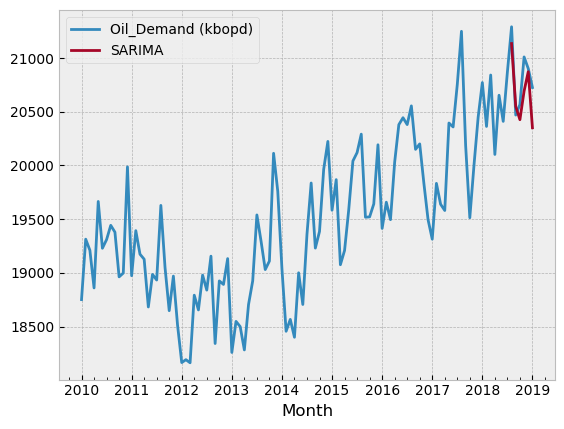

In [44]:
# On récupère les prévisons
pred_demand = sarima.forecast(6)
pred_demand  += mu_train
pred_demand = np.exp(pred_demand)

# On ajoute les prédictions aux données
df_model = data.copy()
index = df_model.index[-6:]
df_model.loc[index, "SARIMA"] = np.around(pred_demand, 2)

df_model.loc["31/01/10":].plot(y=["Oil_Demand (kbopd)", "SARIMA"])
plt.savefig("Charts/Demand_SARIMA.png", bbox_inches = 'tight')
plt.show()

On constate que la prédiction est correcte sur 9 mois. Comme pour les stocks nous avons une bonne prédiction à 6 mois nous utiliserons une période de 6 mois pour tester notre modèle finale.

### Prédiction du WTI

In [45]:
def rmse(y_true, y_pred):
    """Donne le RMSE (Root Mean Square Error) d'une prédiction
    -----------
    Paramètres :
    y_true : Valeurs réelles (array)
    y_pred : Valeurs prédites (array)
    -----------
    Retourne :
    float : RMSE score
    """
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))
    return round(rmse, 2)

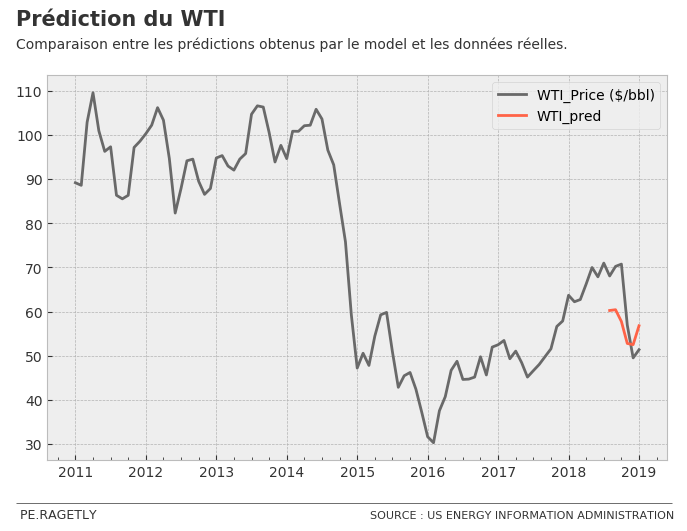

Pour le modèle naif le RMSE est : 13.23
Pour la régression multiple le RMSE est : 7.97


In [46]:
# ajout des prévisions (Stocks et conso)
df = data.loc["31/01/2011":, :].copy()
df.loc[:, "Stock_pred"] = df.loc[:, "Oil_Stock (kbbls)"]
df.loc["31/08/18":, "Stock_pred"] = pred_stock
df.loc[:, "Demand_pred"] = df.loc[:, "Oil_Demand (kbopd)"]
df.loc["31/08/18":, "Demand_pred"] = pred_demand

# Utilisation du modèle
X = df.loc["31/01/2011":, "Prod_lag12":].values
y = df.loc["31/01/2011":, "WTI_Price ($/bbl)"].values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
X_train = X[:-6, :]
y_train = y[:-6]
X_test = X[-6:, :]
y_test = y[-6:]
lin_reg = linear_model.LinearRegression()
model = lin_reg.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ajout du WTI prédit
df.loc["31/08/18":, "WTI_pred"] = y_pred

# Visualisation des résultats
series_plot(df[["WTI_Price ($/bbl)", "WTI_pred"]],
            colors=["dimgrey", "tomato"],
            source="US Energy Information Administration",
            title_s="Prédiction du WTI",
            subtitle_s="Comparaison entre les prédictions obtenus par le model et les données réelles.",
            file_s="Charts/WTI_results")

# Visualisation des RMSE
naive_pred = np.full((6,), df.iloc[-7, 0])
naive_rmse = rmse(df.iloc[-6:, 0].values, naive_pred)
lin_rmse = rmse(df.iloc[-6:, 0].values, y_pred)
print("Pour le modèle naif le RMSE est : {:.2f}".format(naive_rmse))
print("Pour la régression multiple le RMSE est : {:.2f}".format(lin_rmse))

## Annexe Prédiction via un SARIMA

### Analyse de la tendance et de la saisonnalité

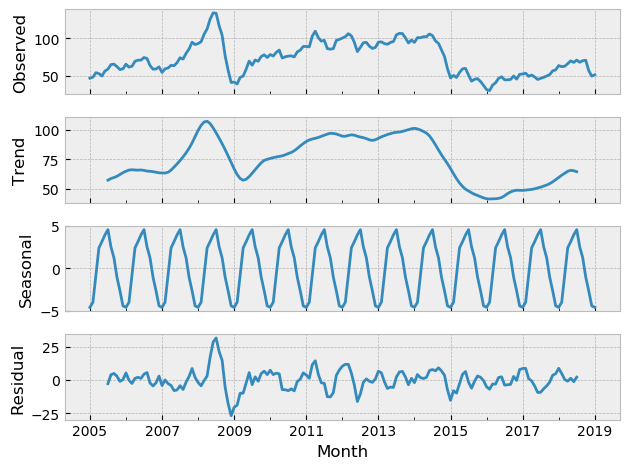

In [47]:
decomp_price = seasonal_decompose(data["WTI_Price ($/bbl)"],  model="additive")

# On réinitialise les paramètres des plots
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('bmh')

# On trace le résultat de la décomposition
decomp_price.plot()
plt.show()

### Analyse des fonction d'autocorrélations

Nous entrainerons le modèle sur le jeu de données tronqué de la dernière année, et comparerons ses résultats avec les données réelles.

In [48]:
data_train = data.loc["31/01/10": "31/12/17", :]

Les processus AR ne s'appliquant que sur des processus centrés, nous allons commencer par centrer les données

In [49]:
mu_train = data_train["WTI_Price ($/bbl)"].mean()
y_train = data_train["WTI_Price ($/bbl)"] - mu_train

Analysons la fonction des auto-corrélations (ACF) pour vérifier s'il est nécessaire de différencier &ndash; présence de tendance et/ou de saisonnalité.

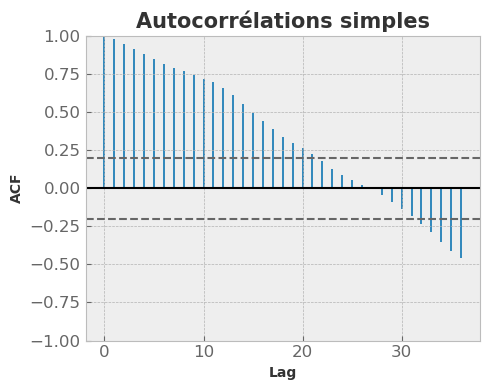

In [50]:
acf_plot(y_train, nlags=36, partial=False, unbiased=True)

La décroissance est lente, on différencie une 1ère fois

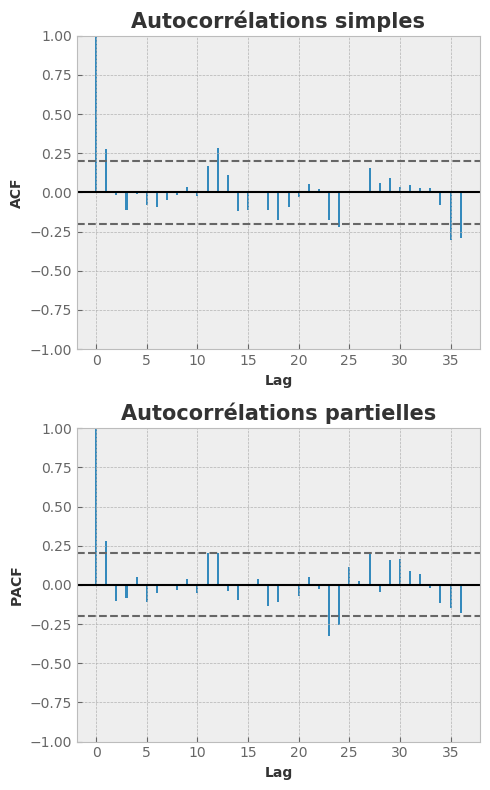

In [51]:
y_dif_1 = y_train.diff(1)[1:]
acf_plot(y_dif_1, nlags=36, partial=True, unbiased=True)

Pour déterminer les paramètres nous garderons en tête le résultat suivant :
  >**Dans la grande majorité des cas p = 0 ou q = 0, et p+q est inférieur ou égale à 3** *(Duke Prof. Robert Nau)*.
 
Après analyse des corrélations nous obtenons les résultats suivants :
- p = 1 : parmi les 3 premiers lags du PACF seul le premier est significatif
- q = 1 : parmi les 3 premiers lags de l'ACF seul le premier est significatif

Nous obtenons donc le modèle suivant, **ARIMA(1,1,1)**.
Vérifions la siginificativité de chaque paramètre et la blancheur des résidus.

### Vérification des hypothèses

In [52]:
sarima = SARIMAX(np.asarray(y_train), order=(1,1,1))
results = sarima.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   96
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -289.684
Date:                Thu, 02 May 2019   AIC                            585.367
Time:                        10:50:14   BIC                            593.029
Sample:                             0   HQIC                           588.463
                                 - 96                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1050      0.322      0.326      0.744      -0.526       0.736
ma.L1          0.1915      0.359      0.534      0.593      -0.511       0.894
sigma2        26.0441      3.544      7.349      0.000      19.098      32.990
===================================================================================
Ljung-Box (Q):                       32.08   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.81   Prob(JB):                         0.75
Heteroskedasticity (H):               0.43   Skew:                            -0.11
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Le coefficient AR n'est pas significatif, testons p=0

In [53]:
sarima = SARIMAX(np.asarray(y_train), order=(0,1,1))
results = sarima.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   96
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -289.760
Date:                Thu, 02 May 2019   AIC                            583.521
Time:                        10:50:14   BIC                            588.629
Sample:                             0   HQIC                           585.585
                                 - 96                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2807      0.112      2.496      0.013       0.060       0.501
sigma2        26.0882      3.529      7.392      0.000      19.171      33.005
===================================================================================
Ljung-Box (Q):                       32.61   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.79   Prob(JB):                         0.70
Heteroskedasticity (H):               0.44   Skew:                            -0.12
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Nous constatons que pour une confiance de test de 5% :
- Tous les paramètres sont significatifs;
- L'absence d'autocorrélation entre résidus est vérifiée (test Ljung-Box, pvalue  0.79)
- Les résidus suivent une distribution normale (pvalue = 0.70)

En revanche l'homoscédasticité n'est pas vérifiée

### Visualisation des prévisions

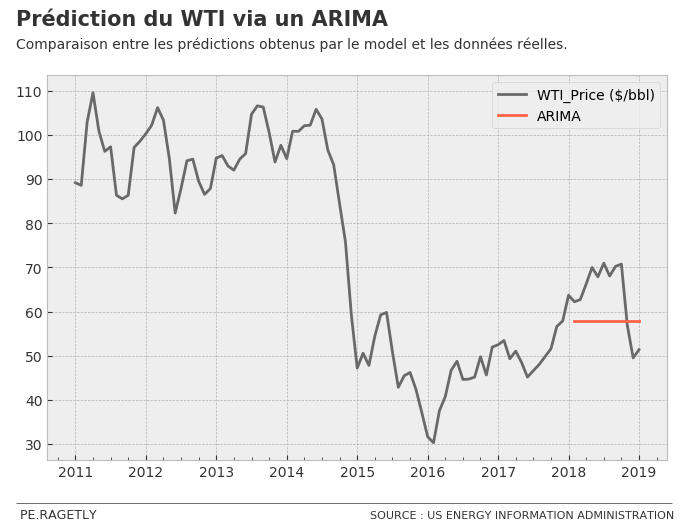

In [54]:
# On récupère les prévisons
pred_train = results.forecast(12)
pred_train += mu_train

# On ajoute les prédictions aux données
df_model = data.copy()
index = df_model.index[-12:]
df_model.loc[index, "ARIMA"] = np.around(pred_train, 2)

# Visualisation des résultats
series_plot(df_model.loc["31/01/11":, ["WTI_Price ($/bbl)", "ARIMA"]],
            colors=["dimgrey", "tomato"],
            source="US Energy Information Administration",
            title_s="Prédiction du WTI via un ARIMA",
            subtitle_s="Comparaison entre les prédictions obtenus par le model et les données réelles.",
            file_s="Charts/WTI_SARIMA")